In [142]:
# deep learning fundamental
# assignment3
# a1832643
# Yanhui Zhao

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
# Set the maximum column, width and other parameters of the display and eliminate the ellipsis in the middle of the incomplete print
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

dataset : Input training data

target : predicted data

start_index : Start point usually is 0 since it will be grouped later

end_index : Set end point as 0

history_size input_length Select target_size as 10

predicted_length Select 1

In [122]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])
    
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)


In [123]:
# compute Rmse
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

In [124]:
# def lstm_model(input_length, input_dim):

#     d=0.3
#     model= Sequential()
#     model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=True))
#     model.add(Dropout(d))

#     model.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False))
#     model.add(Dropout(d))
    
#     model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

#     # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
#     model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
#     return model 


Build the model --

Dropout is used to prevent over-simulation

input length is the length of input time

input_dim is the number of variables, we will have 6 variables 

return_sequences : True is to maintain (batch ,time_steps ,seq_len), set False to the next layer of LSTM will become one-dimensional

loss is trained by mean_squared_error; Optimizer is trained using Adam

In [125]:
# def build_model(input_length, input_dim):
#     d=0.3
#     model= Sequential()
#     model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=True))
    
#     model.add(Dropout(d))
    
#     model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=False))
    
#     model.add(Dropout(d))
    
#     model.add(Dense(1,activation='linear'))
# #linear / softmax (multinomial) / sigmoid (binomial)
    
#     model.compile(loss='mse',optimizer='adam')
#     return model

In [126]:
data = pd.read_csv('APLE.csv',index_col = 'Date', parse_dates=True) # load the stock info
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-18,18.000000,18.000,17.030001,18.000000,12.911796,2197500
2015-05-19,17.920000,19.150,17.920000,18.799999,13.485645,1978700
2015-05-20,18.700001,18.840,18.360001,18.610001,13.349364,717600
2015-05-21,18.600000,18.660,18.020000,18.250000,13.091125,793000
2015-05-22,18.250000,18.400,18.049999,18.209999,13.062433,536200
...,...,...,...,...,...,...
2020-03-26,9.390000,10.235,9.050000,9.570000,9.570000,8239600
2020-03-27,9.000000,9.350,8.610000,9.050000,9.050000,4906400
2020-03-30,9.050000,9.060,8.060000,8.760000,8.760000,4491600


In [127]:
# data.set_index("Date",drop=True,inplace=True)
data.sort_index(inplace=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-18,18.000000,18.000,17.030001,18.000000,12.911796,2197500
2015-05-19,17.920000,19.150,17.920000,18.799999,13.485645,1978700
2015-05-20,18.700001,18.840,18.360001,18.610001,13.349364,717600
2015-05-21,18.600000,18.660,18.020000,18.250000,13.091125,793000
2015-05-22,18.250000,18.400,18.049999,18.209999,13.062433,536200
...,...,...,...,...,...,...
2020-03-26,9.390000,10.235,9.050000,9.570000,9.570000,8239600
2020-03-27,9.000000,9.350,8.610000,9.050000,9.050000,4906400
2020-03-30,9.050000,9.060,8.060000,8.760000,8.760000,4491600


Set Variables. The closing price is the predicted target and the rest are variables

In [128]:
y = data["Adj Close"]
x = data

In [129]:
x

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-18,18.000000,18.000,17.030001,18.000000,12.911796,2197500
2015-05-19,17.920000,19.150,17.920000,18.799999,13.485645,1978700
2015-05-20,18.700001,18.840,18.360001,18.610001,13.349364,717600
2015-05-21,18.600000,18.660,18.020000,18.250000,13.091125,793000
2015-05-22,18.250000,18.400,18.049999,18.209999,13.062433,536200
...,...,...,...,...,...,...
2020-03-26,9.390000,10.235,9.050000,9.570000,9.570000,8239600
2020-03-27,9.000000,9.350,8.610000,9.050000,9.050000,4906400
2020-03-30,9.050000,9.060,8.060000,8.760000,8.760000,4491600


Normalize the data to between 0 and 1, making it faster to train and easier to converge

In [130]:
scaler = MinMaxScaler(feature_range=(0,1))
y = scaler.fit_transform(y.to_frame())
scaler1 = MinMaxScaler(feature_range=(0,1))
x = scaler1.fit_transform(x)

In [131]:
x

array([[0.83121828, 0.80801555, 0.78584847, 0.83080806, 0.65415363,
        0.09860579],
       [0.82614214, 0.88235296, 0.84157792, 0.88131307, 0.70065949,
        0.08737819],
       [0.87563457, 0.8623142 , 0.86912961, 0.8693182 , 0.68961502,
        0.02266558],
       ...,
       [0.26332488, 0.23012286, 0.22417033, 0.24747475, 0.31768425,
        0.2163262 ],
       [0.24175127, 0.23852616, 0.25485285, 0.27335858, 0.35091141,
        0.20164001],
       [0.21256345, 0.21460891, 0.23606761, 0.24242425, 0.3112009 ,
        0.13932891]])

The data is divided into a training set, a validation set and a test set.

In [132]:
x,y = multivariate_data( x ,y , 0 ,None, 10 , 1 ,single_step=True)
split = 0.95
x_, y_  = x[0:int(split*len(x))] , y[0:int(split*len(x))]
x_test, y_test   = x[int(split*len(x)):] , y[int(split*len(x)):]
split = 0.8
x_train, y_train  = x_[:int(split*len(x_))], y_[:int(split*len(x_))]
x_vaild, y_vaild  = x_[int(split*len(x_)):], y_[int(split*len(x_)):]

In [133]:
# x_test
# x_train
# x_vaild
# y_test
# y_train
# y_vaild

In [134]:
train_index = data.index[10:len(x_train) + 10]
val_index = data.index[len(x_train) + 10:len(x_train) + 10 + len(x_vaild)]
print(x_train.shape,y_train.shape,x_vaild.shape,y_vaild.shape,)

(924, 10, 6) (924, 1) (232, 10, 6) (232, 1)


The models are divided into 4 types, one layer of Lstm and one layer of Dense

In [89]:
################0000000000000#################

In [90]:
def lstm_model0(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(32,input_shape=(input_length, input_dim),return_sequences=False)) #布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    model.add(Dropout(d)) # Preventing over-fitting
   
    model.add(Dense(1,activation='linear'))#linear / softmax(多分類) / sigmoid(二分法)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    # The application only observes the loss value, not the accuracy, so remove the metrics option and only the loss value will be displayed for each epoch iteration.
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [91]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist

#######
lstm0 = lstm_model0(10,6)
history_lstm0 = lstm0.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm0.summary()

Epoch 1/1000
21/31 [===================>..........] - ETA: 0s - loss: 0.3222
Epoch 1: val_loss improved from inf to 0.00293, saving model to lstm.best.hdf5
31/31 [==============================] - 2s 18ms/step - loss: 0.2429 - val_loss: 0.0029
Epoch 2/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0473
Epoch 2: val_loss improved from 0.00293 to 0.00058, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 5ms/step - loss: 0.0454 - val_loss: 5.7645e-04
Epoch 3/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0393
Epoch 3: val_loss did not improve from 0.00058
31/31 [==============================] - 0s 5ms/step - loss: 0.0372 - val_loss: 6.3557e-04
Epoch 4/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0316
Epoch 4: val_loss improved from 0.00058 to 0.00049, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 4.9321e-04
Epoch 5/1000
27/31 [===================

Epoch 38/1000
19/31 [=================>............] - ETA: 0s - loss: 0.0144
Epoch 38: val_loss improved from 0.00044 to 0.00043, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 4.2803e-04
Epoch 39/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0127
Epoch 39: val_loss did not improve from 0.00043
31/31 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 4.6691e-04
Epoch 40/1000
31/31 [==============================] - ETA: 0s - loss: 0.0113
Epoch 40: val_loss improved from 0.00043 to 0.00042, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 4.2342e-04
Epoch 41/1000
31/31 [==============================] - ETA: 0s - loss: 0.0130
Epoch 41: val_loss did not improve from 0.00042
31/31 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 4.9793e-04
Epoch 42/1000
17/31 [===============>..............] - ETA: 

Epoch 74/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0079
Epoch 74: val_loss did not improve from 0.00036
31/31 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 4.2316e-04
Epoch 75/1000
16/31 [==============>...............] - ETA: 0s - loss: 0.0086
Epoch 75: val_loss did not improve from 0.00036
31/31 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 4.1084e-04
Epoch 76/1000
18/31 [================>.............] - ETA: 0s - loss: 0.0085
Epoch 76: val_loss did not improve from 0.00036
31/31 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 4.2693e-04
Epoch 77/1000
17/31 [===============>..............] - ETA: 0s - loss: 0.0099
Epoch 77: val_loss did not improve from 0.00036
31/31 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 5.1997e-04
Epoch 78/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0093
Epoch 78: val_loss did not improve from 0.00036
31/31 

Epoch 111/1000
31/31 [==============================] - ETA: 0s - loss: 0.0059
Epoch 111: val_loss did not improve from 0.00031
31/31 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 3.9801e-04
Epoch 112/1000
17/31 [===============>..............] - ETA: 0s - loss: 0.0057
Epoch 112: val_loss did not improve from 0.00031
31/31 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 3.4590e-04
Epoch 113/1000
16/31 [==============>...............] - ETA: 0s - loss: 0.0059
Epoch 113: val_loss did not improve from 0.00031
31/31 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 4.8289e-04
Epoch 114/1000
18/31 [================>.............] - ETA: 0s - loss: 0.0063
Epoch 114: val_loss did not improve from 0.00031
31/31 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 3.7784e-04
Epoch 115/1000
16/31 [==============>...............] - ETA: 0s - loss: 0.0062
Epoch 115: val_loss did not improve from 0.00

Epoch 185/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0031
Epoch 185: val_loss did not improve from 0.00029
31/31 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 2.9212e-04
Epoch 186/1000
17/31 [===============>..............] - ETA: 0s - loss: 0.0030
Epoch 186: val_loss did not improve from 0.00029
31/31 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 2.9929e-04
Epoch 187/1000
18/31 [================>.............] - ETA: 0s - loss: 0.0031
Epoch 187: val_loss did not improve from 0.00029
31/31 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 3.5340e-04
Epoch 188/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0029
Epoch 188: val_loss did not improve from 0.00029
31/31 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 4.0883e-04
Epoch 189/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0030
Epoch 189: val_loss did not improve from 0.00

Epoch 222/1000
19/31 [=================>............] - ETA: 0s - loss: 0.0024
Epoch 222: val_loss did not improve from 0.00028
31/31 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 3.1890e-04
Epoch 223/1000
18/31 [================>.............] - ETA: 0s - loss: 0.0026
Epoch 223: val_loss did not improve from 0.00028
31/31 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 2.7887e-04
Epoch 224/1000
17/31 [===============>..............] - ETA: 0s - loss: 0.0027
Epoch 224: val_loss did not improve from 0.00028
31/31 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 2.7884e-04
Epoch 225/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 225: val_loss did not improve from 0.00028
31/31 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 2.7960e-04
Epoch 226/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0022
Epoch 226: val_loss did not improve from 0.00

31/31 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 3.4824e-04
Epoch 297/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0012
Epoch 297: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 3.0318e-04
Epoch 298/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0012
Epoch 298: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 3.5844e-04
Epoch 299/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0012
Epoch 299: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 3.2106e-04
Epoch 300/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0012
Epoch 300: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 2.9310e-04
Epoch 301/1000
30/31 [===========

Epoch 334/1000
17/31 [===============>..............] - ETA: 0s - loss: 0.0013
Epoch 334: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.2542e-04
Epoch 335/1000
31/31 [==============================] - ETA: 0s - loss: 0.0011
Epoch 335: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 2.8816e-04
Epoch 336/1000
16/31 [==============>...............] - ETA: 0s - loss: 0.0015
Epoch 336: val_loss did not improve from 0.00027
31/31 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.5268e-04
Epoch 337/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.0011
Epoch 337: val_loss improved from 0.00027 to 0.00026, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 2.6141e-04
Epoch 338/1000
23/31 [=====================>........] - ETA: 0s - loss: 0.0013
Epoch 338

Epoch 371/1000
18/31 [================>.............] - ETA: 0s - loss: 0.0012
Epoch 371: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 4ms/step - loss: 9.1937e-04 - val_loss: 2.9931e-04
Epoch 372/1000
17/31 [===============>..............] - ETA: 0s - loss: 0.0012
Epoch 372: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 4ms/step - loss: 9.1970e-04 - val_loss: 3.6032e-04
Epoch 373/1000
31/31 [==============================] - ETA: 0s - loss: 8.5574e-04
Epoch 373: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 5ms/step - loss: 8.5574e-04 - val_loss: 3.2907e-04
Epoch 374/1000
28/31 [==========================>...] - ETA: 0s - loss: 9.3412e-04
Epoch 374: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 5ms/step - loss: 9.1405e-04 - val_loss: 3.2596e-04
Epoch 375/1000
28/31 [==========================>...] - ETA: 0s - loss: 9.1533e-04
Epoch 375: val_lo

31/31 [==============================] - 0s 4ms/step - loss: 8.2003e-04 - val_loss: 2.9501e-04
Epoch 444/1000
28/31 [==========================>...] - ETA: 0s - loss: 8.0199e-04
Epoch 444: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 5ms/step - loss: 8.0438e-04 - val_loss: 2.7265e-04
Epoch 445/1000
29/31 [===========================>..] - ETA: 0s - loss: 8.1679e-04
Epoch 445: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 5ms/step - loss: 8.0609e-04 - val_loss: 2.9948e-04
Epoch 446/1000
30/31 [============================>.] - ETA: 0s - loss: 8.4326e-04
Epoch 446: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 4ms/step - loss: 8.4146e-04 - val_loss: 3.0729e-04
Epoch 447/1000
28/31 [==========================>...] - ETA: 0s - loss: 7.7289e-04
Epoch 447: val_loss did not improve from 0.00026
31/31 [==============================] - 0s 5ms/step - loss: 7.6165e-04 - val_loss: 2.8306e-

Epoch 480/1000
25/31 [=======================>......] - ETA: 0s - loss: 8.5989e-04
Epoch 480: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 5ms/step - loss: 7.8756e-04 - val_loss: 3.0145e-04
Epoch 481/1000
22/31 [====================>.........] - ETA: 0s - loss: 8.5548e-04
Epoch 481: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 6ms/step - loss: 7.5684e-04 - val_loss: 3.3179e-04
Epoch 482/1000
23/31 [=====================>........] - ETA: 0s - loss: 7.8678e-04
Epoch 482: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 6ms/step - loss: 7.1519e-04 - val_loss: 3.0173e-04
Epoch 483/1000
22/31 [====================>.........] - ETA: 0s - loss: 8.4545e-04
Epoch 483: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 6ms/step - loss: 7.6612e-04 - val_loss: 2.8180e-04
Epoch 484/1000
22/31 [====================>.........] - ETA: 0s - loss: 8.5083e-04
Epoch 484

16/31 [==============>...............] - ETA: 0s - loss: 7.4230e-04
Epoch 552: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 4ms/step - loss: 5.7490e-04 - val_loss: 3.8831e-04
Epoch 553/1000
29/31 [===========================>..] - ETA: 0s - loss: 5.2603e-04
Epoch 553: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 6ms/step - loss: 5.4212e-04 - val_loss: 3.8867e-04
Epoch 554/1000
25/31 [=======================>......] - ETA: 0s - loss: 5.9582e-04
Epoch 554: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 8ms/step - loss: 5.7677e-04 - val_loss: 3.6448e-04
Epoch 555/1000
20/31 [==================>...........] - ETA: 0s - loss: 6.8309e-04
Epoch 555: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 6ms/step - loss: 5.9939e-04 - val_loss: 4.0826e-04
Epoch 556/1000
31/31 [==============================] - ETA: 0s - loss: 5.5462e-04
Epoch 556: val_loss did 

17/31 [===============>..............] - ETA: 0s - loss: 5.7798e-04
Epoch 624: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 4ms/step - loss: 4.7248e-04 - val_loss: 4.2158e-04
Epoch 625/1000
17/31 [===============>..............] - ETA: 0s - loss: 5.0328e-04
Epoch 625: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 4ms/step - loss: 4.5857e-04 - val_loss: 3.9628e-04
Epoch 626/1000
18/31 [================>.............] - ETA: 0s - loss: 4.6356e-04
Epoch 626: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 4ms/step - loss: 4.5045e-04 - val_loss: 4.4310e-04
Epoch 627/1000
17/31 [===============>..............] - ETA: 0s - loss: 5.0995e-04
Epoch 627: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 4ms/step - loss: 4.5676e-04 - val_loss: 4.8717e-04
Epoch 628/1000
17/31 [===============>..............] - ETA: 0s - loss: 5.2220e-04
Epoch 628: val_loss did 

17/31 [===============>..............] - ETA: 0s - loss: 4.9028e-04
Epoch 696: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 4ms/step - loss: 4.3518e-04 - val_loss: 5.1860e-04
Epoch 697/1000
30/31 [============================>.] - ETA: 0s - loss: 4.2627e-04
Epoch 697: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 5ms/step - loss: 4.2725e-04 - val_loss: 7.0564e-04
Epoch 698/1000
30/31 [============================>.] - ETA: 0s - loss: 4.5623e-04
Epoch 698: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 5ms/step - loss: 4.5511e-04 - val_loss: 5.1099e-04
Epoch 699/1000
28/31 [==========================>...] - ETA: 0s - loss: 4.3601e-04
Epoch 699: val_loss did not improve from 0.00025
31/31 [==============================] - 0s 5ms/step - loss: 4.4580e-04 - val_loss: 4.9585e-04
Epoch 700/1000
31/31 [==============================] - ETA: 0s - loss: 4.0732e-04
Epoch 700: val_loss did 

2/2 [==============================] - 0s 3ms/step


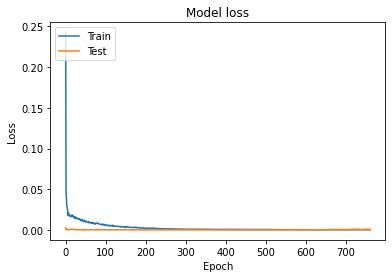

8/8 [==============================] - 0s 1ms/step


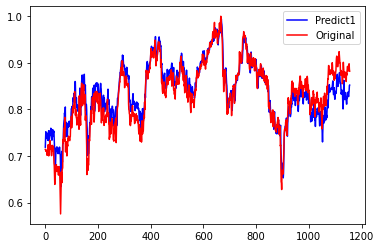

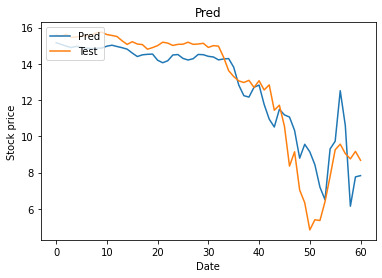

rmse of model 0 =  1.2720894529538236


In [92]:
lstm0_train  = lstm0.predict(x_train)
lstm0_val = lstm0.predict(x_vaild)
lstm0_pred = lstm0.predict(x_test)
plt.plot(history_lstm0.history['loss'])
plt.plot(history_lstm0.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# input test dataset into model for prediction
pred = lstm0.predict(x_train) #pre 
pred_=lstm0.predict(x_vaild) #pre1
fc=np.concatenate((pred,pred_))
y_real=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict1')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')

plt.legend()
plt.show()

lstm0_pred= scaler.inverse_transform(lstm0_pred) #lstm0pre # restore of predicted data - back-normalisation from (0, 1) to the original range
y_test = scaler.inverse_transform(y_test.reshape(-1,1)) # restore to real data - back-normalisation from (0, 1) to the original range


# Plot a comparison curve between real data and predicted data
plt.figure()
plt.plot(lstm0_pred)
plt.plot(y_test)
plt.title('Pred')
plt.ylabel('Stock price')
plt.xlabel('Date')
plt.legend(['Pred', 'Test'], loc='upper left')
plt.show()
print('rmse of model 0 = ', root_mean_squared_error(lstm0_pred,y_test))

In [93]:
# calculate MSE (Mean Square Error)
mse = mean_squared_error(y_test,lstm0_pred)
# calculate RMSE (root mean square error)
rmse = sqrt(mean_squared_error(y_test,lstm0_pred))
# calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test,lstm0_pred)
# calculate R square
r_square = r2_score(y_test,lstm0_pred)
print('Mean Square Error: %.6f' % mse)
print('Root Mean Squared Error: %.6f' % rmse)
print('Mean absolute error: %.6f' % mae)
print('R_squared: %.6f' % r_square)

Mean Square Error: 1.618212
Root Mean Squared Error: 1.272089
Mean absolute error: 0.955694
R_squared: 0.847179


In [94]:
#############11111111111111###############

In [115]:
def lstm_model1(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(64,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    
    model.add(Dense(1,activation='linear'))#linear / softmax (multinomial) / sigmoid (binomial)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [116]:
lstm1 =lstm_model1(10,6)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
    ]
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [ my_callbacks,checkpoint]
callbacks=call_backlist
history1 = lstm1.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm1.summary()

Epoch 1/1000
28/31 [==========================>...] - ETA: 0s - loss: 0.0574
Epoch 1: val_loss improved from inf to 0.01021, saving model to lstm.best.hdf5
31/31 [==============================] - 4s 29ms/step - loss: 0.0535 - val_loss: 0.0102
Epoch 2/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0170
Epoch 2: val_loss improved from 0.01021 to 0.00593, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 12ms/step - loss: 0.0158 - val_loss: 0.0059
Epoch 3/1000
31/31 [==============================] - ETA: 0s - loss: 0.0146
Epoch 3: val_loss improved from 0.00593 to 0.00252, saving model to lstm.best.hdf5
31/31 [==============================] - 0s 11ms/step - loss: 0.0146 - val_loss: 0.0025
Epoch 4/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0143
Epoch 4: val_loss did not improve from 0.00252
31/31 [==============================] - 0s 14ms/step - loss: 0.0138 - val_loss: 0.0051
Epoch 5/1000
29/31 [===========================>

29/31 [===========================>..] - ETA: 0s - loss: 0.0100
Epoch 76: val_loss did not improve from 0.00085
31/31 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 8.6340e-04
Epoch 77/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0110
Epoch 77: val_loss did not improve from 0.00085
31/31 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0011
Epoch 78/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0117
Epoch 78: val_loss did not improve from 0.00085
31/31 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0011
Epoch 79/1000
31/31 [==============================] - ETA: 0s - loss: 0.0106
Epoch 79: val_loss did not improve from 0.00085
31/31 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 9.4738e-04
Epoch 80/1000
31/31 [==============================] - ETA: 0s - loss: 0.0106
Epoch 80: val_loss did not improve from 0.00085
31/31 [=================

Epoch 113/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0098
Epoch 113: val_loss did not improve from 0.00071
31/31 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 7.7387e-04
Epoch 114/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.0099
Epoch 114: val_loss did not improve from 0.00071
31/31 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 7.3843e-04
Epoch 115/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 115: val_loss did not improve from 0.00071
31/31 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 7.7471e-04
Epoch 116/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0099
Epoch 116: val_loss did not improve from 0.00071
31/31 [==============================] - 0s 13ms/step - loss: 0.0091 - val_loss: 7.3173e-04
Epoch 117/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 117: val_loss did not improve from 

27/31 [=========================>....] - ETA: 0s - loss: 0.0053
Epoch 186: val_loss did not improve from 0.00040
31/31 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 5.9405e-04
Epoch 187/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 187: val_loss did not improve from 0.00040
31/31 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 5.0675e-04
Epoch 188/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0047
Epoch 188: val_loss did not improve from 0.00040
31/31 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 5.1627e-04
Epoch 189/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 189: val_loss did not improve from 0.00040
31/31 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 4.0978e-04
Epoch 190/1000
31/31 [==============================] - ETA: 0s - loss: 0.0042
Epoch 190: val_loss improved from 0.00040 to 0.00035, sa

31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 259: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 9.5995e-04
Epoch 260/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015
Epoch 260: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 7.4475e-04
Epoch 261/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 261: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 262/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015
Epoch 262: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 7.8594e-04
Epoch 263/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.0016
Epoch 263: val_loss did not improve from 0.00030
31/31 [====

Epoch 332/1000
31/31 [==============================] - ETA: 0s - loss: 6.2600e-04
Epoch 332: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 13ms/step - loss: 6.2600e-04 - val_loss: 5.6967e-04
Epoch 333/1000
30/31 [============================>.] - ETA: 0s - loss: 6.4067e-04
Epoch 333: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 14ms/step - loss: 6.4100e-04 - val_loss: 5.5416e-04
Epoch 334/1000
30/31 [============================>.] - ETA: 0s - loss: 6.4222e-04
Epoch 334: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 13ms/step - loss: 6.3466e-04 - val_loss: 7.1781e-04
Epoch 335/1000
30/31 [============================>.] - ETA: 0s - loss: 6.5675e-04
Epoch 335: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 6.5140e-04 - val_loss: 5.5109e-04
Epoch 336/1000
31/31 [==============================] - ETA: 0s - loss: 5.9412e-04
Epoch

Epoch 368/1000
31/31 [==============================] - ETA: 0s - loss: 5.3732e-04
Epoch 368: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 10ms/step - loss: 5.3732e-04 - val_loss: 7.3076e-04
Epoch 369/1000
31/31 [==============================] - ETA: 0s - loss: 5.3133e-04
Epoch 369: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 5.3133e-04 - val_loss: 7.2593e-04
Epoch 370/1000
27/31 [=========================>....] - ETA: 0s - loss: 5.9811e-04
Epoch 370: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 12ms/step - loss: 5.8908e-04 - val_loss: 7.3698e-04
Epoch 371/1000
31/31 [==============================] - ETA: 0s - loss: 6.3391e-04
Epoch 371: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 6.3391e-04 - val_loss: 4.9995e-04
Epoch 372/1000
29/31 [===========================>..] - ETA: 0s - loss: 6.1720e-04
Epoch

Epoch 404/1000
31/31 [==============================] - ETA: 0s - loss: 5.4385e-04
Epoch 404: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 5.4385e-04 - val_loss: 0.0010
Epoch 405/1000
31/31 [==============================] - ETA: 0s - loss: 5.6092e-04
Epoch 405: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 10ms/step - loss: 5.6092e-04 - val_loss: 9.5830e-04
Epoch 406/1000
31/31 [==============================] - ETA: 0s - loss: 5.6468e-04
Epoch 406: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 10ms/step - loss: 5.6468e-04 - val_loss: 7.8325e-04
Epoch 407/1000
27/31 [=========================>....] - ETA: 0s - loss: 6.1570e-04
Epoch 407: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 12ms/step - loss: 6.0519e-04 - val_loss: 7.0129e-04
Epoch 408/1000
31/31 [==============================] - ETA: 0s - loss: 6.0175e-04
Epoch 408

31/31 [==============================] - ETA: 0s - loss: 4.5619e-04
Epoch 476: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 4.5619e-04 - val_loss: 9.7606e-04
Epoch 477/1000
30/31 [============================>.] - ETA: 0s - loss: 4.3833e-04
Epoch 477: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 4.4079e-04 - val_loss: 0.0011
Epoch 478/1000
28/31 [==========================>...] - ETA: 0s - loss: 4.4763e-04
Epoch 478: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 16ms/step - loss: 4.5636e-04 - val_loss: 7.7981e-04
Epoch 479/1000
31/31 [==============================] - ETA: 0s - loss: 4.7422e-04
Epoch 479: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 10ms/step - loss: 4.7422e-04 - val_loss: 4.9606e-04
Epoch 480/1000
31/31 [==============================] - ETA: 0s - loss: 6.1334e-04
Epoch 480: val_loss did 

29/31 [===========================>..] - ETA: 0s - loss: 3.9971e-04
Epoch 512: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 12ms/step - loss: 4.0136e-04 - val_loss: 9.8341e-04
Epoch 513/1000
29/31 [===========================>..] - ETA: 0s - loss: 5.2764e-04
Epoch 513: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 12ms/step - loss: 5.2955e-04 - val_loss: 7.5100e-04
Epoch 514/1000
28/31 [==========================>...] - ETA: 0s - loss: 4.3318e-04
Epoch 514: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 4.3378e-04 - val_loss: 8.8564e-04
Epoch 515/1000
31/31 [==============================] - ETA: 0s - loss: 4.4464e-04
Epoch 515: val_loss did not improve from 0.00030
31/31 [==============================] - 0s 11ms/step - loss: 4.4464e-04 - val_loss: 0.0011
Model: "sequential_8"
_________________________________________________________________
 Layer (type)      

2/2 [==============================] - 0s 4ms/step


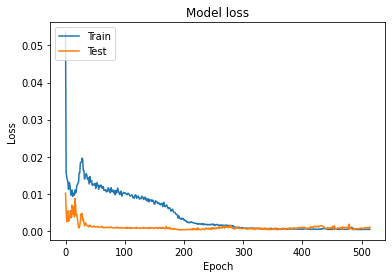

In [117]:
lstm1_train  = lstm1.predict(x_train)
lstm1_val = lstm1.predict(x_vaild)
lstm1_pre = lstm1.predict(x_test)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

8/8 [==============================] - 0s 4ms/step


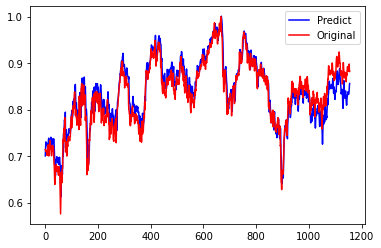

In [118]:

pred = lstm1.predict(x_train)
pred_=lstm1.predict(x_vaild)
fc=np.concatenate((pred,pred_)) # pre, pre1
y_real=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')

plt.legend()
plt.show()


2/2 [==============================] - 0s 5ms/step


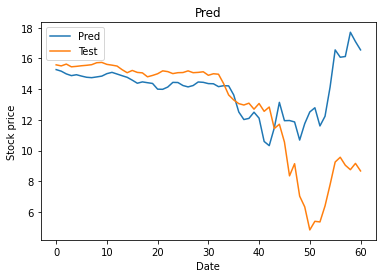

rmse of model 1 =  3.3263417478812944


In [119]:
lstm1_pred = lstm1.predict(x_test) # lstm1pre
pred = scaler.inverse_transform(lstm1_pred) # pre lstm1pre
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure()
plt.plot(pred)
plt.plot(y_test)
plt.title('Pred')
plt.ylabel('Stock price')
plt.xlabel('Date')
plt.legend(['Pred', 'Test'], loc='upper left')
plt.show()

print('rmse of model 1 = ', root_mean_squared_error(pred,y_test))

In [120]:
# calculate MSE (Mean Square Error)
mse = mean_squared_error(y_test,pred)
# calculate RMSE (root mean square error)
rmse = sqrt(mean_squared_error(y_test,pred))
# calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test,pred)
# calculate R square
r_square = r2_score(y_test,pred)
print('Mean Square Error: %.6f' % mse)
print('Root Mean Squared Error: %.6f' % rmse)
print('Mean absolute error: %.6f' % mae)
print('R_squared: %.6f' % r_square)

Mean Square Error: 11.064549
Root Mean Squared Error: 3.326342
Mean absolute error: 2.109223
R_squared: -0.044914


In [99]:
###########222222222222#############

In [135]:
def lstm_model2(input_length, input_dim):

    d=0.3
    model= Sequential()
    model.add(LSTM(256,input_shape=(input_length, input_dim),return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(128,input_shape=(input_length, input_dim),return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,activation='linear'))#linear / softmax (multinomial) / sigmoid (binomial)
    model.add(Dropout(d))

    model.add(Dense(1,activation='linear'))#linear / softmax (multinomial) / sigmoid (binomial)

    # optimizer = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='mse',optimizer='adam')#loss=mse/categorical_crossentropy
    return model 

In [136]:
my_callbacks = [
tf.keras.callbacks.EarlyStopping(patience=300, monitor = 'val_loss')
] ######## Training in the training group, selected using the validation group
filepath="lstm.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, mode='min',save_best_only=True)

call_backlist = [my_callbacks,checkpoint]
lstm2 = lstm_model2(10,6) 
history_lstm2 = lstm2.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=1000,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
# history_lstm2 = lstm2.fit( x_train, y_train, batch_size=30,shuffle=False , epochs=500,validation_data=(x_vaild,y_vaild),callbacks=call_backlist)
lstm2.summary()

Epoch 1/1000
31/31 [==============================] - ETA: 0s - loss: 0.0750
Epoch 1: val_loss improved from inf to 0.00171, saving model to lstm.best.hdf5
31/31 [==============================] - 4s 44ms/step - loss: 0.0750 - val_loss: 0.0017
Epoch 2/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0402
Epoch 2: val_loss did not improve from 0.00171
31/31 [==============================] - 1s 22ms/step - loss: 0.0404 - val_loss: 0.0022
Epoch 3/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0350
Epoch 3: val_loss did not improve from 0.00171
31/31 [==============================] - 1s 31ms/step - loss: 0.0344 - val_loss: 0.0023
Epoch 4/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0316
Epoch 4: val_loss did not improve from 0.00171
31/31 [==============================] - 1s 29ms/step - loss: 0.0315 - val_loss: 0.0053
Epoch 5/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0320
Epoch 5: val_loss improved from 0.00171 to 

Epoch 39/1000
31/31 [==============================] - ETA: 0s - loss: 0.0167
Epoch 39: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 22ms/step - loss: 0.0167 - val_loss: 0.0010
Epoch 40/1000
31/31 [==============================] - ETA: 0s - loss: 0.0164
Epoch 40: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 23ms/step - loss: 0.0164 - val_loss: 8.9782e-04
Epoch 41/1000
31/31 [==============================] - ETA: 0s - loss: 0.0163
Epoch 41: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 22ms/step - loss: 0.0163 - val_loss: 8.8905e-04
Epoch 42/1000
31/31 [==============================] - ETA: 0s - loss: 0.0156
Epoch 42: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 22ms/step - loss: 0.0156 - val_loss: 8.9957e-04
Epoch 43/1000
31/31 [==============================] - ETA: 0s - loss: 0.0156
Epoch 43: val_loss did not improve from 0.00078
31/31 

Epoch 77/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0104
Epoch 77: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 28ms/step - loss: 0.0104 - val_loss: 8.8980e-04
Epoch 78/1000
31/31 [==============================] - ETA: 0s - loss: 0.0108
Epoch 78: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 32ms/step - loss: 0.0108 - val_loss: 8.8624e-04
Epoch 79/1000
31/31 [==============================] - ETA: 0s - loss: 0.0104
Epoch 79: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 29ms/step - loss: 0.0104 - val_loss: 8.8212e-04
Epoch 80/1000
29/31 [===========================>..] - ETA: 0s - loss: 0.0099
Epoch 80: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 28ms/step - loss: 0.0101 - val_loss: 9.0159e-04
Epoch 81/1000
31/31 [==============================] - ETA: 0s - loss: 0.0104
Epoch 81: val_loss did not improve from 0.00078
31

31/31 [==============================] - 1s 25ms/step - loss: 0.0088 - val_loss: 8.8446e-04
Epoch 115/1000
31/31 [==============================] - ETA: 0s - loss: 0.0087
Epoch 115: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 24ms/step - loss: 0.0087 - val_loss: 9.3561e-04
Epoch 116/1000
31/31 [==============================] - ETA: 0s - loss: 0.0083
Epoch 116: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 22ms/step - loss: 0.0083 - val_loss: 0.0011
Epoch 117/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0088
Epoch 117: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 23ms/step - loss: 0.0089 - val_loss: 0.0011
Epoch 118/1000
31/31 [==============================] - ETA: 0s - loss: 0.0078
Epoch 118: val_loss did not improve from 0.00078
31/31 [==============================] - 1s 22ms/step - loss: 0.0078 - val_loss: 9.9521e-04
Epoch 119/1000
31/31 [==============

Epoch 188/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 188: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 22ms/step - loss: 0.0023 - val_loss: 7.6725e-04
Epoch 189/1000
30/31 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 189: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 8.7995e-04
Epoch 190/1000
31/31 [==============================] - ETA: 0s - loss: 0.0022
Epoch 190: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 27ms/step - loss: 0.0022 - val_loss: 7.9045e-04
Epoch 191/1000
31/31 [==============================] - ETA: 0s - loss: 0.0023
Epoch 191: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 23ms/step - loss: 0.0023 - val_loss: 7.4510e-04
Epoch 192/1000
31/31 [==============================] - ETA: 0s - loss: 0.0024
Epoch 192: val_loss did not improve from 

30/31 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 262: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 30ms/step - loss: 0.0016 - val_loss: 5.5071e-04
Epoch 263/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 263: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 5.2943e-04
Epoch 264/1000
31/31 [==============================] - ETA: 0s - loss: 0.0016
Epoch 264: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 6.6613e-04
Epoch 265/1000
31/31 [==============================] - ETA: 0s - loss: 0.0015
Epoch 265: val_loss did not improve from 0.00044
31/31 [==============================] - 1s 22ms/step - loss: 0.0015 - val_loss: 5.7447e-04
Epoch 266/1000
31/31 [==============================] - ETA: 0s - loss: 0.0017
Epoch 266: val_loss improved from 0.00044 to 0.00043, sa

Epoch 299/1000
31/31 [==============================] - ETA: 0s - loss: 8.9806e-04
Epoch 299: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 22ms/step - loss: 8.9806e-04 - val_loss: 5.6827e-04
Epoch 300/1000
31/31 [==============================] - ETA: 0s - loss: 8.2954e-04
Epoch 300: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 26ms/step - loss: 8.2954e-04 - val_loss: 5.6559e-04
Epoch 301/1000
31/31 [==============================] - ETA: 0s - loss: 8.6570e-04
Epoch 301: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 25ms/step - loss: 8.6570e-04 - val_loss: 6.2751e-04
Epoch 302/1000
30/31 [============================>.] - ETA: 0s - loss: 8.1888e-04
Epoch 302: val_loss did not improve from 0.00043
31/31 [==============================] - 1s 27ms/step - loss: 8.1656e-04 - val_loss: 6.1931e-04
Epoch 303/1000
31/31 [==============================] - ETA: 0s - loss: 8.5238e-04
Epoch

Epoch 335/1000
31/31 [==============================] - ETA: 0s - loss: 6.6930e-04
Epoch 335: val_loss improved from 0.00037 to 0.00037, saving model to lstm.best.hdf5
31/31 [==============================] - 1s 25ms/step - loss: 6.6930e-04 - val_loss: 3.7002e-04
Epoch 336/1000
31/31 [==============================] - ETA: 0s - loss: 6.5663e-04
Epoch 336: val_loss improved from 0.00037 to 0.00036, saving model to lstm.best.hdf5
31/31 [==============================] - 1s 25ms/step - loss: 6.5663e-04 - val_loss: 3.6130e-04
Epoch 337/1000
31/31 [==============================] - ETA: 0s - loss: 6.0004e-04
Epoch 337: val_loss improved from 0.00036 to 0.00036, saving model to lstm.best.hdf5
31/31 [==============================] - 1s 24ms/step - loss: 6.0004e-04 - val_loss: 3.5734e-04
Epoch 338/1000
31/31 [==============================] - ETA: 0s - loss: 5.7999e-04
Epoch 338: val_loss improved from 0.00036 to 0.00032, saving model to lstm.best.hdf5
31/31 [==============================] -

Epoch 406/1000
31/31 [==============================] - ETA: 0s - loss: 6.5285e-04
Epoch 406: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 22ms/step - loss: 6.5285e-04 - val_loss: 7.7607e-04
Epoch 407/1000
30/31 [============================>.] - ETA: 0s - loss: 6.0938e-04
Epoch 407: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 24ms/step - loss: 6.0829e-04 - val_loss: 6.1679e-04
Epoch 408/1000
30/31 [============================>.] - ETA: 0s - loss: 7.2136e-04
Epoch 408: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 25ms/step - loss: 7.2464e-04 - val_loss: 4.9267e-04
Epoch 409/1000
31/31 [==============================] - ETA: 0s - loss: 6.1711e-04
Epoch 409: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 24ms/step - loss: 6.1711e-04 - val_loss: 4.1469e-04
Epoch 410/1000
31/31 [==============================] - ETA: 0s - loss: 5.6045e-04
Epoch

31/31 [==============================] - ETA: 0s - loss: 5.8317e-04
Epoch 478: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 22ms/step - loss: 5.8317e-04 - val_loss: 5.1065e-04
Epoch 479/1000
31/31 [==============================] - ETA: 0s - loss: 6.1671e-04
Epoch 479: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 23ms/step - loss: 6.1671e-04 - val_loss: 3.3426e-04
Epoch 480/1000
31/31 [==============================] - ETA: 0s - loss: 6.1421e-04
Epoch 480: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 23ms/step - loss: 6.1421e-04 - val_loss: 4.5364e-04
Epoch 481/1000
31/31 [==============================] - ETA: 0s - loss: 5.6918e-04
Epoch 481: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 22ms/step - loss: 5.6918e-04 - val_loss: 4.8127e-04
Epoch 482/1000
31/31 [==============================] - ETA: 0s - loss: 5.9236e-04
Epoch 482: val_loss 

31/31 [==============================] - ETA: 0s - loss: 5.7916e-04
Epoch 514: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 23ms/step - loss: 5.7916e-04 - val_loss: 6.0187e-04
Epoch 515/1000
31/31 [==============================] - ETA: 0s - loss: 5.6230e-04
Epoch 515: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 24ms/step - loss: 5.6230e-04 - val_loss: 7.2375e-04
Epoch 516/1000
31/31 [==============================] - ETA: 0s - loss: 6.1540e-04
Epoch 516: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 25ms/step - loss: 6.1540e-04 - val_loss: 5.3967e-04
Epoch 517/1000
31/31 [==============================] - ETA: 0s - loss: 5.4668e-04
Epoch 517: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 23ms/step - loss: 5.4668e-04 - val_loss: 5.6204e-04
Epoch 518/1000
31/31 [==============================] - ETA: 0s - loss: 5.5151e-04
Epoch 518: val_loss 

30/31 [============================>.] - ETA: 0s - loss: 5.2279e-04
Epoch 586: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 25ms/step - loss: 5.3761e-04 - val_loss: 8.2585e-04
Epoch 587/1000
31/31 [==============================] - ETA: 0s - loss: 5.5300e-04
Epoch 587: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 22ms/step - loss: 5.5300e-04 - val_loss: 5.6335e-04
Epoch 588/1000
31/31 [==============================] - ETA: 0s - loss: 6.1567e-04
Epoch 588: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 22ms/step - loss: 6.1567e-04 - val_loss: 0.0010
Epoch 589/1000
31/31 [==============================] - ETA: 0s - loss: 6.9282e-04
Epoch 589: val_loss did not improve from 0.00032
31/31 [==============================] - 1s 22ms/step - loss: 6.9282e-04 - val_loss: 8.7014e-04
Epoch 590/1000
31/31 [==============================] - ETA: 0s - loss: 6.1968e-04
Epoch 590: val_loss did 

2/2 [==============================] - 0s 8ms/step


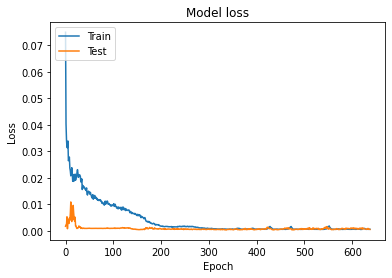

In [137]:
lstm1train  = lstm2.predict(x_train)
lstm1val = lstm2.predict(x_vaild)
lstm1pre = lstm2.predict(x_test)
plt.plot(history_lstm2.history['loss'])
plt.plot(history_lstm2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


8/8 [==============================] - 0s 8ms/step


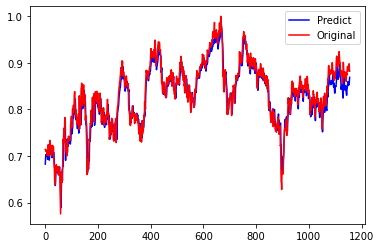

In [138]:

pred = lstm2.predict(x_train)
pred_=lstm2.predict(x_vaild)
fc=np.concatenate((pred,pred_))
yreal=np.concatenate((y_train,y_vaild))
plt.figure(facecolor='white')
pd.Series(fc.reshape(-1)).plot(color='blue', label='Predict')
pd.Series(yreal.reshape(-1)).plot(color='red', label='Original')

plt.legend()
plt.show()


2/2 [==============================] - 0s 9ms/step


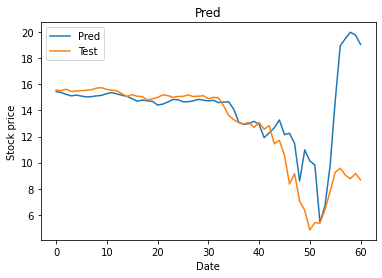

rmse of model 2 =  3.3486065840692754


In [139]:
lstm2_pred = lstm2.predict(x_test)
pred = scaler.inverse_transform(lstm2_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure()
plt.plot(pred)
plt.plot(y_test)
plt.title('Pred')
plt.ylabel('Stock price')
plt.xlabel('Date')
plt.legend(['Pred', 'Test'], loc='upper left')
plt.show()

print('rmse of model 2 = ', root_mean_squared_error(pred,y_test))

In [140]:
# calculate MSE (Mean Square Error)
mse = mean_squared_error(y_test,pred)
# calculate RMSE (root mean square error)
rmse = sqrt(mean_squared_error(y_test,pred))
# calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test,pred)
# calculate R square
r_square = r2_score(y_test,pred)
print('Mean Square Error: %.6f' % mse)
print('Root Mean Squared Error: %.6f' % rmse)
print('Mean absolute error: %.6f' % mae)
print('R_squared: %.6f' % r_square)

Mean Square Error: 11.213166
Root Mean Squared Error: 3.348607
Mean absolute error: 1.661180
R_squared: -0.058949
